In [51]:
import jcopdl
import numpy as np
import matplotlib.pyplot as plt

In [52]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [53]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [54]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.78, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = MultilabelDataset("data/train_label.csv", "data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [55]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

# Arsitektur & Config

### Contoh cara pakai Pretrained-Model

In [56]:
from torchvision.models import mobilenet_v2

weights = torch.load('model/mobilenet_v2-b0353104.pth', map_location="cpu")
mnet = mobilenet_v2(pretrained=False)

mnet.load_state_dict(weights)
mnet = mnet.to(device)

for param in mnet.parameters():
    param.requires_grad = False

In [57]:
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

In [58]:
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        weights = torch.load('model/mobilenet_v2-b0353104.pth', map_location="cpu")
        mnet = mobilenet_v2(pretrained=False)
        mnet.load_state_dict(weights)
        self.mnet = mnet.to(device)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [59]:
config = set_config({
    "output_size": len(train_set.classes),
    "batch_size" : bs,
    "crop_size"  : crop_size
    
})

## Phase 1: Adaptation (lr standard + patience kecil)

In [63]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model")

In [64]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 0.4903 | Test_cost  = 0.3805 | 




Epoch     2
Train_cost  = 0.3479 | Test_cost  = 0.3106 | 




Epoch     3
Train_cost  = 0.3041 | Test_cost  = 0.2813 | 




Epoch     4
Train_cost  = 0.2691 | Test_cost  = 0.2566 | 




Epoch     5
Train_cost  = 0.2561 | Test_cost  = 0.2529 | 




Epoch     6
Train_cost  = 0.2470 | Test_cost  = 0.2374 | 




Epoch     7
Train_cost  = 0.2390 | Test_cost  = 0.2301 | 




Epoch     8
Train_cost  = 0.2472 | Test_cost  = 0.2272 | 




Epoch     9
Train_cost  = 0.2256 | Test_cost  = 0.2312 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2272




Epoch    10
Train_cost  = 0.2256 | Test_cost  = 0.2210 | 




Epoch    11
Train_cost  = 0.2198 | Test_cost  = 0.2244 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2210




Epoch    12
Train_cost  = 0.2145 | Test_cost  = 0.2304 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2210
==> Execute Early Stopping at epoch: 12 | Best test_cost: 0.2210
==> Best model is saved at model


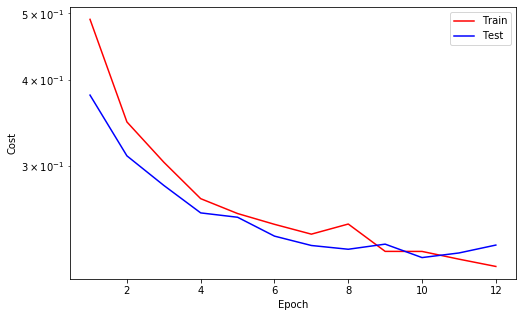

In [65]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Phase 2: Fine-tuning (lr dikecilin, patience ditambah)

In [ ]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

In [ ]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Predict

In [45]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5).to(torch.float32)
preds

# Sanity Check

In [47]:
def convert_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred==1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

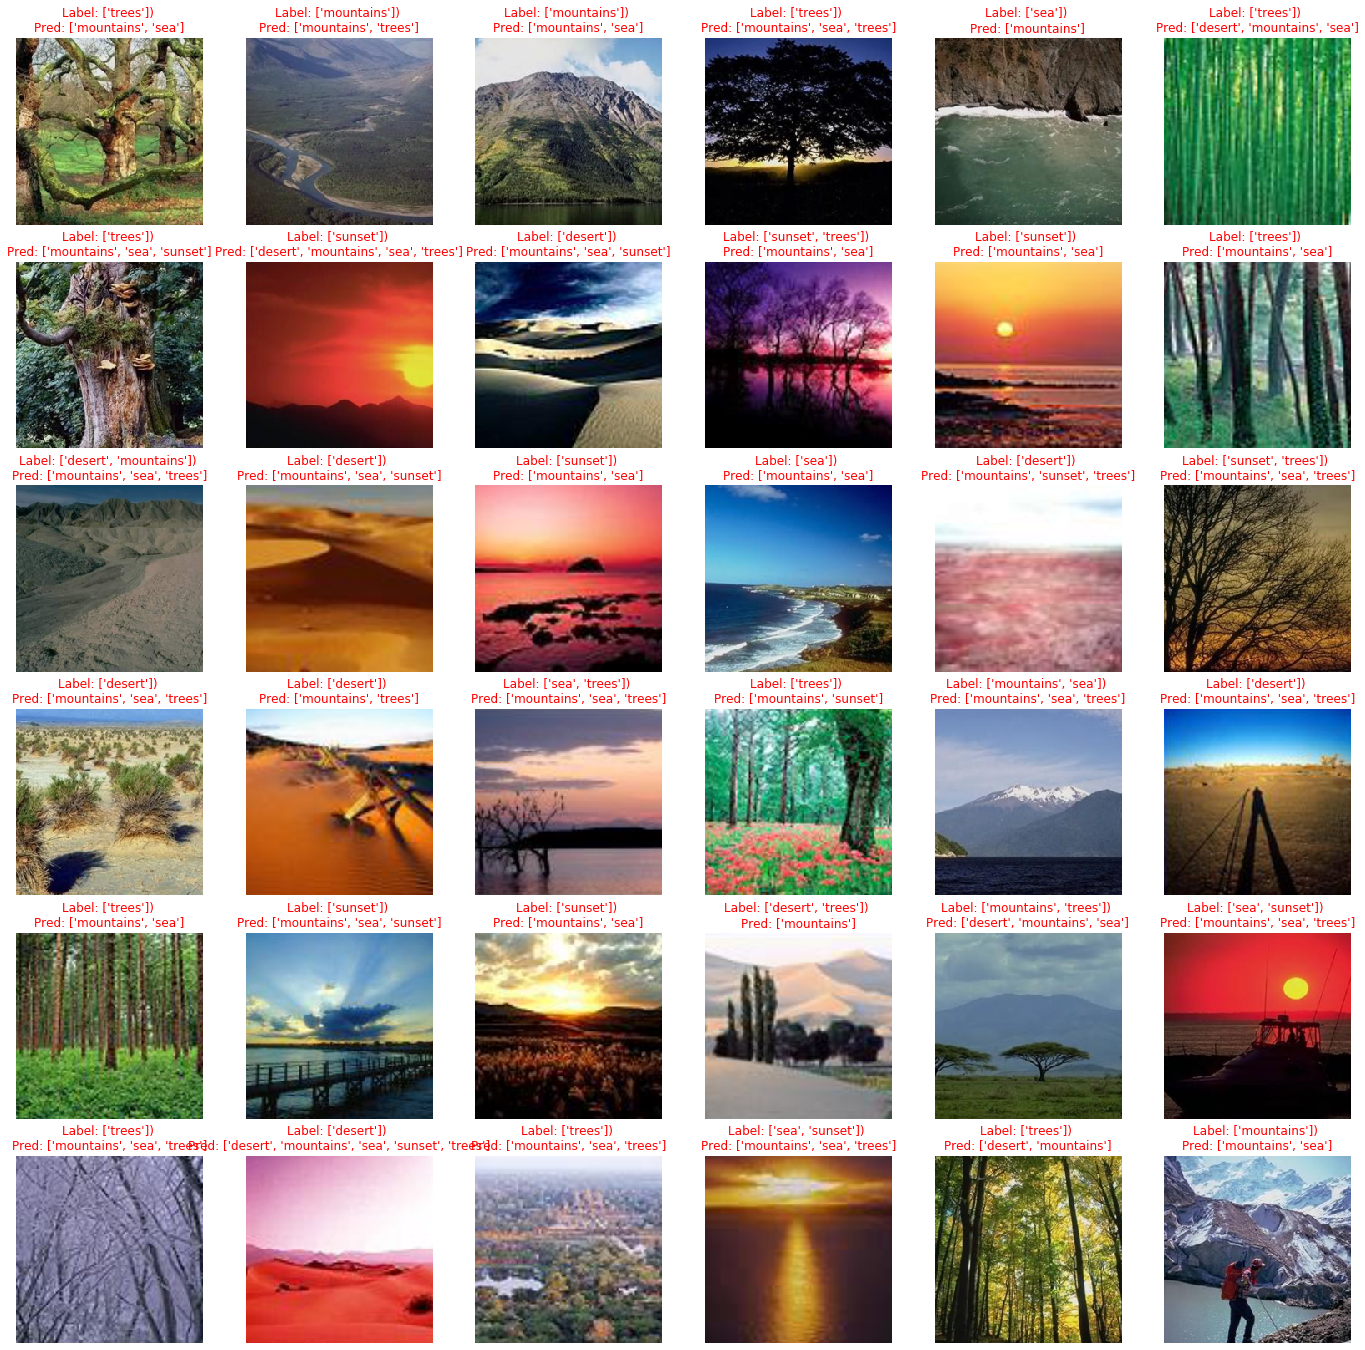

In [50]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1,2,0).cpu())
    font = {"color" : 'r'} if (pred != label).any() else {"color": 'g'}
    label, pred = convert_to_label(label), convert_to_label(pred)
    ax.set_title(f"Label: {label}) \nPred: {pred}", fontdict=font);
    ax.axis('off');